# Project 4 - Time Series Analysis - FINAL

## Sophie Wu

## 1. Brief
**[Potential use of findings / project motivation]** <br>
UBS's Global Research department makes stock recommendations based on company and sector fundamental analysis.
Europe Food Retailers is a sector covered by the department with combined market capitalisation >EUR100bn. Within Europe, the UK Food Retail sector is particularly competitive as is evidenced by the supermarket price war in 2014/15. Pricing pressure weighs on company top line (revenue), profitability (food retailers are also highly operationally leveraged) and by extension company valuation. UK Food CPI is an useful macro indicator to track for forecasting food retailers' top line growth. Given data published by ONS is lagged by 1 month, we see a need to forecast UK CPI (Food) index. 

**[Data questions]**<br>
With this in mind, this data analysis project aims to achieve the below:<br>
1) Determine whether univariate models using only historical UK CPI data are adequate for predicting future CPI level within 0.50% error (as measure by %Mean Absolute Error). We set the error tolerance to 0.50%, given average historical monthly food inflation has been c.0.50% for the past 30 years in the UK, so any models with errors greater than this level would not be useful to be used as input for company topline forecasting.

## 2. Load libraries

In [3]:
# for data and matrix manipulation
import pandas as pd 
import numpy as np 

# for data visualisation
import matplotlib.pyplot as plt 
%matplotlib inline 
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# for pathname manipulation and making http requests 
import os 
import requests 

# for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

# for iterations
import itertools

# to filter out warnings
import warnings
warnings.filterwarnings("ignore")


## 3. Source the data
**[Sourcing the relevant data]** <br>
We look at CPI 01.1.Food published by the ONS. 
CPI is the official measure of inflation of consumer prices of the United Kingdom. <br>
The classification has three levels of detail; 01.1 Food is at the group or three-digit level and captures consumer prices of items such as: bread and cereals, meat, fish, milk cheese and eggs, oils and fats, fruit, vegs, and sugar. <br>
The CPI dataset contains a series of float values representing the CPI level, with associated timestamps.

**[Data sharing guidelines]** <br>
With respect to data sharing issues and guidelines, this is an open source dataset and can be freely accessed and shared. The ONS (Office of National Statistics) is a government organisation (the executive office of the UK Statistics Authority, a non-ministerial department which reports directly to the UK Parliament).

In [2]:
#locate data source url, download dataset and save in designated folder.

url = "https://www.ons.gov.uk/generator?format=csv&uri=/economy/inflationandpriceindices/timeseries/d7c8/mm23"
response = requests.get(url)
with open(os.path.join("/Users/SophieMQWu/Desktop/data-fellowship/PROJECTS", "uk_cpi_june19.csv"), 'wb') as f:
    f.write(response.content)

## 4. Explore and transform the data

In [3]:
df = pd.read_csv("uk_cpi_june19.csv")
df.head(10)

,Title,CPI INDEX 01.1 : FOOD 2015=100
0,CDID,D7C8
1,Source dataset ID,MM23
2,PreUnit,NaN
3,Unit,"Index, base year = 100"
4,Release date,17-07-2019
5,Next release,14 August 2019
6,Important notes,NaN
7,1988,48.8
8,1989,51.6
9,1990,55.7


In [25]:
# We remove the firt 7 rows of the dataframe which is not part of the actual data series.
df = pd.read_csv("uk_cpi_june19.csv", skiprows = 7)
df.head()

,Important notes,Unnamed: 1
0,1988,48.8
1,1989,51.6
2,1990,55.7
3,1991,58.6
4,1992,59.5


In [26]:
print(df.columns)

Index(['Important notes', 'Unnamed: 1'], dtype='object')


In [27]:
# Rename columns as 'date' and 'index'
df = df.rename(columns={'Important notes': 'date', 'Unnamed: 1':'index'})
df.head()

,date,index
0,1988,48.8
1,1989,51.6
2,1990,55.7
3,1991,58.6
4,1992,59.5


In [28]:
df.shape

(535, 2)

Consumer price data starts in 1988. And we know, from the original 'df.head()' that the data goes up to July-2019.
From the output we can see that the table contains 535 rows and 2 columns, suggesting the dataframe might contain data other than annual consumer prices, e.g. monthly data.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 2 columns):
date     535 non-null object
index    535 non-null float64
dtypes: float64(1), object(1)
memory usage: 8.4+ KB


We see that there are no misssing value in the dataframe. As the number of observations for each column is 535, same number of rows we saw before in `shape`. However, the data type for 'date' is `object`, we were expecting numerical or datetime type. A quick look at a sample of data in the line below shows that the dataframe contains annual, quarterly and monthly data.

In [9]:
print(df.sample(10))

         date  index
506  2017 FEB   98.9
111   2008 Q1   79.7
352  2004 APR   70.5
341  2003 MAY   69.8
58    1994 Q4   61.1
220  1993 APR   60.7
279  1998 MAR   64.3
198  1991 JUN   59.2
75    1999 Q1   66.3
263  1996 NOV   64.3


We choose to look at monthly data, which is more likely to exhibit dynamic relations than data which are further apart. We remove yearly and quartely data from the dataframe.

In [29]:
# Keep rows with monthly data only
months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
df_months = df[df['date'].str.contains('|'.join(months))]

In [30]:
df_months.head()

,date,index
157,1988 JAN,48.2
158,1988 FEB,48.5
159,1988 MAR,48.6
160,1988 APR,48.9
161,1988 MAY,49.0


In [12]:
df_months.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 157 to 534
Data columns (total 2 columns):
date     378 non-null object
index    378 non-null float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


Data starts from 1988 and ends in July-2019, so if we only have monthly data left in the dataframe, we should see (2018-1988+1)*12+7 = 378 observations. This is the same as the number of entries left in the dataframe. We can be reasonably sure that only monthly data remains.

The datatype of 'date' is still an object'. We need to convert these into datetime type for time series analysis.

In [31]:
from datetime import datetime
df_months['date'] = pd.to_datetime(df_months['date'], format ='%Y %b')
df_months.head()

,date,index
157,1988-01-01,48.2
158,1988-02-01,48.5
159,1988-03-01,48.6
160,1988-04-01,48.9
161,1988-05-01,49.0


We set the 'date' column as the index.

In [32]:
df_months.set_index('date', inplace = True)

In [33]:
df_months.head()

,index
date,
1988-01-01,48.2
1988-02-01,48.5
1988-03-01,48.6
1988-04-01,48.9
1988-05-01,49.0


In [34]:
# convert 'index' into a series, ts. and check that the new variable is a pandas.Series object
ts = df_months['index']
type(ts)

pandas.core.series.Series

In [35]:
ts.head()

date
1988-01-01    48.2
1988-02-01    48.5
1988-03-01    48.6
1988-04-01    48.9
1988-05-01    49.0
Name: index, dtype: float64

In [36]:
ts.describe()

count    378.000000
mean      76.168519
std       17.168237
min       48.200000
25%       64.200000
50%       69.750000
75%       96.700000
max      104.700000
Name: index, dtype: float64

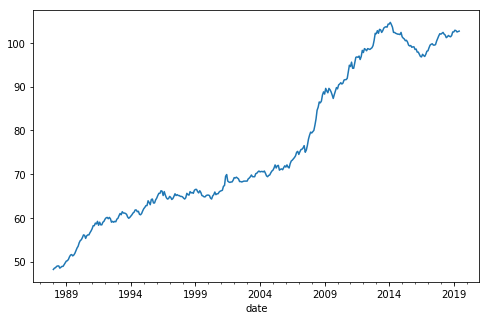

In [19]:
# plot the data
ts.plot(figsize = [8,5])

The series is non-stationary usually with an upward underlying trend (mean changes with time), with the exception of between 2014 and 2016 (this could be reflect the 'supermarket price war' period that we mentioned in the brief). We expect the 'd' parameter in our ARIMA(p,d,q) ≠ 0. It's not immediately obvious whether the data exhibits seasonality. We explore further below.

## 4. Data Analysis to find ARIMA(p,d,q) parameters

### 4.1 Decomposition

Cursory visualisation of the data suggests the data is additive as the seasonality/residuals do not increase with the trend.

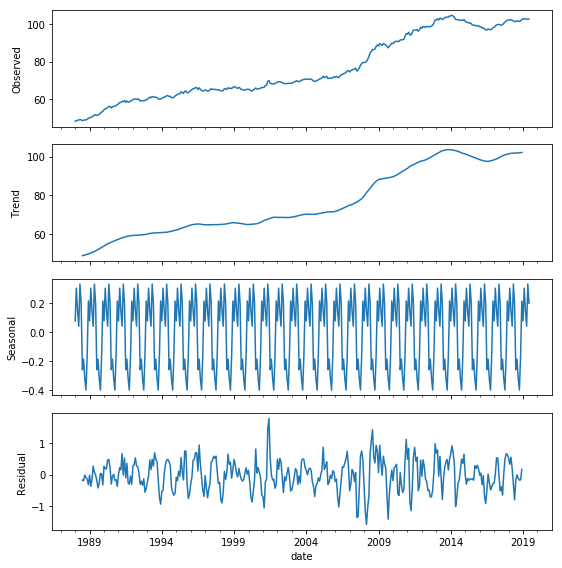

In [20]:
# seasonal_decompose time series data and visualise
rcParams['figure.figsize'] = 8, 8
decomposition = seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

Decomposition analysis suggests that the original data is made up of an underlying trend (i.e. non-stationary), a non-systematic residual component as well as a seasonal component in the data, which repeats on an annual basis (i.e. (freq = 12)). No noticeable pattern left over in the residuals component of the series, suggesting 'additive' model was the appropriate choice.

### 4.2 Testing for stationarity

We commented earlier that the plot of the underlying trend suggests data is not stationary. We formally test this here with KPSS test where null hypothesis = stationary. We reject the null if p-value < 0.05. (use a 5% significance level)

In [48]:
# KPSS test on our time series
kpss(ts)

(2.0818781692614516,
 0.01,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value is < significance level 5%, so we reject the null. Data is not stationary.
We can also plot a correlogram to see this non-stationarity visually. 

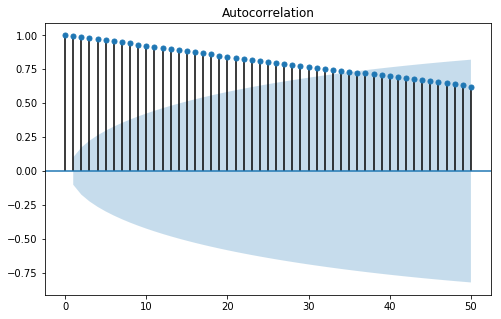

In [22]:
# plotting correlogram
rcParams['figure.figsize'] = 8, 5
plot_acf(ts, lags = 50)
plt.show()

The autocorrelation function describes how well the present value of the series is related with its past values and linear decay in ACF is typical of a nonstationary time series. We also plot the PACF function below.

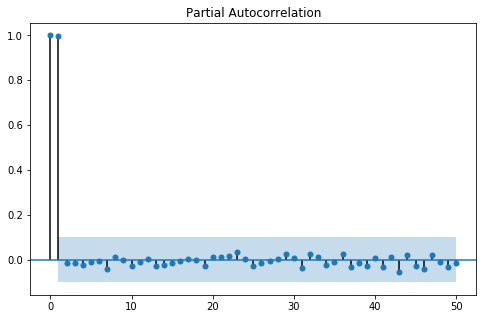

In [23]:
# plotting PACF
rcParams['figure.figsize'] = 8, 5
plot_pacf(ts, lags = 50)
plt.show()

We see significant spike only at lag 1, which suggests that all the higher-order correlation of this non-stationary series are merely due to the propagation of the autocorrelation at lag 1 (all the higher order autocorrelation are effectively explained by the lag-1 autocorrelation. This indicates that **in the absence of differencing, an AR(1) model should be used**. However, the AR(1) term in this model would likely turn out to be equivalent to a first difference, because the estimated AR(1) coefficient will be almost exactly equal to 1. Ŷt = μ + Yt-1 (a random walk with drift). This is also telling us that we need to first difference the series to gain stationarity.

### 4.3 Transforming the data, and determining parameters of ARIMA(p,d,q)

ARIMA modelling requires stationarity.
We need to transform the data to get stationarity.
We see that the mean changes (usually increases) as time goes on, but variance appears roughly constant. 
We transform the data using first-order differencing, this will essentially give us 'monthly' inflation data, which we call 'ts_diff' below.

In [24]:
ts_diff = ts.diff()
ts_diff.head()

date
1988-01-01    NaN
1988-02-01    0.3
1988-03-01    0.1
1988-04-01    0.3
1988-05-01    0.1
Name: index, dtype: float64

In [25]:
# remove the NaN.
ts_diff.dropna(inplace = True)
ts_diff.head()

date
1988-02-01    0.3
1988-03-01    0.1
1988-04-01    0.3
1988-05-01    0.1
1988-06-01    0.0
Name: index, dtype: float64

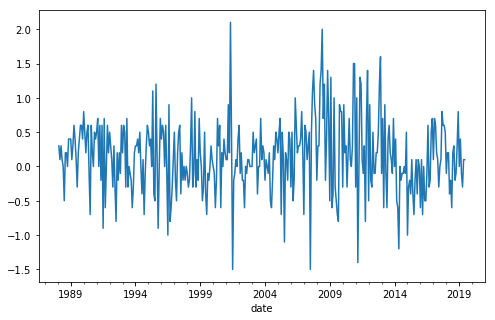

In [26]:
# plotting the transformed series
ts_diff.plot(figsize = [8,5])

Appears to have removed the underlying trend in the data. We perform the KPSS test again to confirm.

In [46]:
# KPSS test
kpss(ts_diff)

(0.10952463858058399,
 0.1,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value is > 5% significance level, we fail to reject the null. 'inf_monthly' seems stationary.

In [28]:
# we get the autocorrelation values for 40 lags.
acf(ts_diff, nlags=40)

array([ 1.        ,  0.11816298,  0.05575827,  0.09329578, -0.02890478,
        0.02256036,  0.13172892,  0.02113194,  0.00605028,  0.0978103 ,
        0.03253948,  0.00626959,  0.31997375, -0.04462629,  0.02237923,
        0.00841184, -0.01742294, -0.04080593,  0.0372601 , -0.05655454,
       -0.00827329,  0.0338832 , -0.07539704, -0.02570453,  0.34254094,
        0.04673904,  0.01590415,  0.02698928, -0.03776028, -0.04821358,
        0.04400234, -0.02586365, -0.0754446 ,  0.03213201, -0.03495402,
       -0.09749583,  0.30917635,  0.02837377, -0.02372434,  0.01387753,
       -0.10669991])

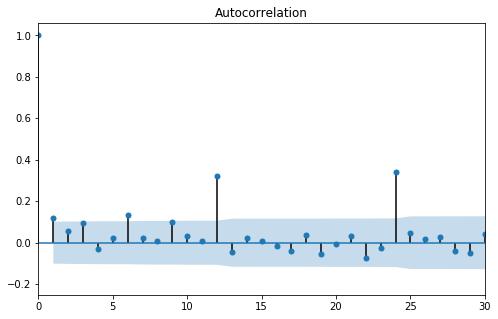

In [29]:
# plotting ACF
rcParams['figure.figsize'] = 8, 5
plot_acf(ts_diff)
plt.xlim(0,30)
plt.show()

<font color='red'>================================</font> <br>
<font color='red'> ==>> d=1 <<== (first order of differencing) </font>  <br>
<font color='red'>================================</font> <br>
The correct amount of differencing is the lowest order of differencing that yields a time series whose ACF plot decays fairly rapidly to zero.
The autocorrelations here are small and patternless (barring some seasonality). First-order differencing seems adequate.
We've identified the degree of integration required for our ARIMA(p,d,q) model.
Correlogram also suggests that there's seasonality in the data, with autocorrelation peaking every 12 periods. When there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window => **we will need to use SARIMA**.
ARIMA model does not support direct modelling of seasonal component of the series.

<font color='red'>================================</font> <br>
<font color='red'> ==>> q=1 <<== (lag=q) </font>  <br>
<font color='red'>================================</font> <br>
The ACF plot, also informs us on the q parameter of the ARIMA model; how many MA terms to include.
As a rule of thumb, order q is the lag value after which ACF crosses the upper confidence interval for the first time.
After 1 lag, the plot is coming within critical boundaries barring repeate spikes at the multiples of the seasonal window, so we set q = 1.

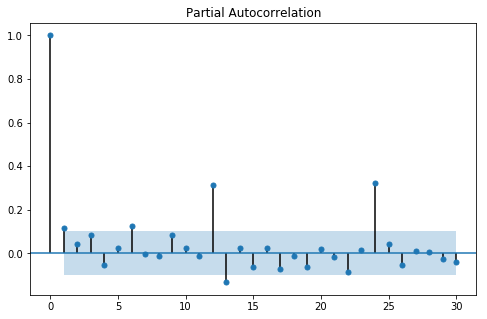

In [30]:
# plotting PACF
plot_pacf(ts_diff, lags=30)
plt.show()

<font color='red'>================================</font> <br>
<font color='red'> ==>> p=1 <<== (lag=p) </font>  <br>
<font color='red'>================================</font> <br>
The PACF plot informs us on the p parameter of the ARMIMA model; how many ACF terms to include. 
As a rule of thumb, order p is the lag value after which ACF crosses the upper confidence interval for the first time.
After 1 lag, the plot is coming within critical boundaries barring repeate spikes at the multiples of the seasonal window, so we set p = 1.

### 4.4 Determining hyperparameters for SARIMA(p,d,q)(P,D,Q)m

Configuring SARIMA requires selecting hyperparameters for both trend and seasonal elements of the series.
The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.
We know from graphical analysis that that m parameter is likely 12.
The trend and seasonality parameters can be configured again by analysing ACF and PACF plots, or by using grid search to iteratively explore different parameters. (likely yield more reliable outcome).

For each combination of parameters, we fit a new SARIMA model with the `SARIMAX()` function and assess the overall quality according to some criterion. The optimal set of parameters will be be the one that yields the best performance according to our criterion of interest. We use **two different methods**, the first method's criterion uses RMSE (root mean-squared-error) and the second method uses AIC (akaike information criterion which penalises the loss of degrees of freedom that occurs when a model is expanded).


### 4.4.1 Grid search - method 1 - with *RMSE* as selection criterion

In [33]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [34]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [35]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [36]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [37]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [38]:
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [39]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1]
	d_params = [0, 1]
	q_params = [0, 1]
	t_params = ['n','c']
	P_params = [0, 1]
	D_params = [0, 1]
	Q_params = [0, 1]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

Running the below code can take a considerably long time. To shorten the runtime, we restrict the test size to 80 (ideally this should be bigger, eg. c.75% of the dataset). In the code in the above line, we also restrict the config list to [0,1] only and ['n', 'c'] (i.e. we iterate through no constant and constant).
Our initial plot of the data shows that slope of the trend changes over time. This is more akin to stochastic trend models (e.g. drift models) instead of deterministic trend models. We therefore choose to not iterate through 't' and 'ct'.

In [41]:
if __name__ == '__main__':
	data = ts
	print(data.shape)
	# data split
	n_test = 80
	# model configs
	cfg_list = sarima_configs(seasonal=[12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

(378,)
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 101.053
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 2.701
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'n']] 3.363
 > Model[[(0, 0, 0), (1, 1, 0, 12), 'n']] 2.607
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 2.524
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'n']] 3.085
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'c']] 28.046
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 53.690
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'c']] 2.968
 > Model[[(0, 0, 0), (1, 1, 1, 12), 'n']] 2.925
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'c']] 17.926
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'c']] 2.748
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'c']] 3.140
 > Model[[(0, 0, 1), (0, 0, 0, 12), 'n']] 51.132
 > Model[[(0, 0, 0), (1, 1, 0, 12), 'c']] 2.723
 > Model[[(0, 0, 1), (0, 1, 0, 12), 'n']] 1.466
 > Model[[(0, 0, 0), (1, 1, 1, 12), 'c']] 2.787
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'c']] 2.855
 > Model[[(0, 0, 1), (0, 1, 1, 12), 'n']] 1.407
 > Model[[(0, 0, 1), (0, 0, 1, 12), 'n']] 28.495
 > Model[[(0, 0, 1), (1, 0

The configurations and error for the top three configurations are reported. <br>
<font color='red'>=====================================</font> <br>
<font color='red'> ==>> (1,1,1)         <<== Order(p,d,q) </font> <br>
<font color='red'> ==>> (1,0,1)         <<== Seasonal Order(P,D,Q) </font> <br>
<font color='red'> ==>> (no trend, 'n') <<== Trend Parameter </font> <br>
<font color='red'>=====================================</font> <br>

### 4.4.2 Grid search - method 2 - with *AIC* as selection criterion

In [44]:
# iterate through all combinations of p,d,q within the range of 0,2 for each parameter 

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# first create a dataframe to be filled with model evaluation metrics we are interested in
foo = pd.DataFrame({'SARIMAX model': [], 
                    'AIC':[]
                   })
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(ts,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()
            # we append the evaluation metrics we get for each iteration into a single table
            foo = foo.append({'SARIMAX model': [param, param_seasonal], 
                              'AIC': results.aic
                             }, ignore_index=True)     
            
        except:
            continue
# we sort table from low to high AIC 
foo = foo.sort_values(by = 'AIC')
foo.head()

,SARIMAX model,AIC
61,"[(1, 1, 1), (1, 0, 1, 12)]",496.593973
59,"[(1, 1, 1), (0, 1, 1, 12)]",496.729214
53,"[(1, 1, 0), (1, 0, 1, 12)]",499.145342
51,"[(1, 1, 0), (0, 1, 1, 12)]",499.585913
29,"[(0, 1, 1), (1, 0, 1, 12)]",499.914709


This method also concludes that SARIMA(1,1,1)(1,0,1)12 is the most optimal with the lowest AIC.

## 5. Building the SARIMA(1,1,1)(1,0,1)12 model

In [271]:
# train/test split our data
train = ts[:'31-12-2017'].dropna()
test = ts['01-01-2018':].dropna()

# fitting the SARIMA model
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12), 
                enforce_stationarity = False, enforce_invertibility = False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              index   No. Observations:                  360
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -237.399
Date:                            Sun, 21 Jul 2019   AIC                            484.798
Time:                                    19:52:26   BIC                            504.016
Sample:                                01-01-1988   HQIC                           492.451
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8388      0.091      9.247      0.000       0.661       1.017
ma.L1         -0.7180      0.117     -6.136      0.000      -0.947      -0.489
ar.S.L12       0.8938      0.038     23.344      0.000       0.819       0.969
ma.S.L12      -0.6701      0.068     -9.810      0.000      -0.804      -0.536
sigma2         0.2271      0.014     15.850      0.000       0.199       0.255
===================================================================================
Ljung-Box (Q):                       43.90   Jarque-Bera (JB):                15.95
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# train/test split our data
train = ts[:'31-12-2017'].dropna()
test = ts['01-01-2018':].dropna()

# fitting the SARIMA model
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12), 
                enforce_stationarity = False, enforce_invertibility = False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              index   No. Observations:                  360
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -237.399
Date:                            Sun, 24 Nov 2019   AIC                            484.798
Time:                                    14:20:46   BIC                            504.016
Sample:                                01-01-1988   HQIC                           492.451
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8388      0.091      9.247      0.000       0.661       1.017
ma.L1         -0.7180      0.117     -6.136      0.000      -0.947      -0.489
ar.S.L12       0.8938      0.038     23.344      0.000       0.819       0.969
ma.S.L12      -0.6701      0.068     -9.810      0.000      -0.804      -0.536
sigma2         0.2271      0.014     15.850      0.000       0.199       0.255
===================================================================================
Ljung-Box (Q):                       43.90   Jarque-Bera (JB):                15.95
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p-values of all variables in the model are significant (<5% significance level). We therefore retain all features.

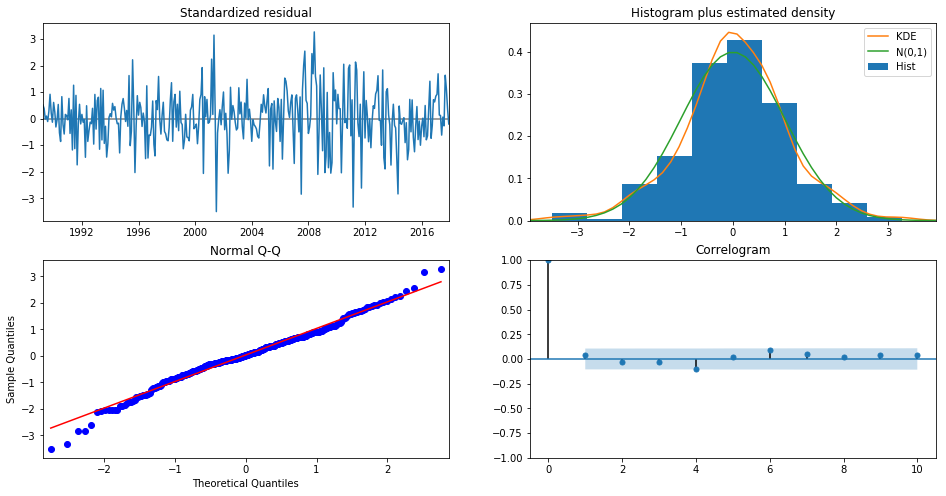

In [272]:
# we plot some diagnostic plots below
results.plot_diagnostics(figsize=(16, 8))
plt.show()

A good and unbiased model should have uncorrelated residuals that are normally distributed with zero mean. <br>
1). The KDE line closely follows the N(0,1) line. <br>
2). The qq plot shows that the ordered distribution of residuals follows the linear trend from a standard normal distribution with N(0,1). <br>
3). Residuals over time don't display obvious seasonality and appear to be white noise. This is confirmed by the correlogram which shows that residuals are not correlated with lagged values of itself.

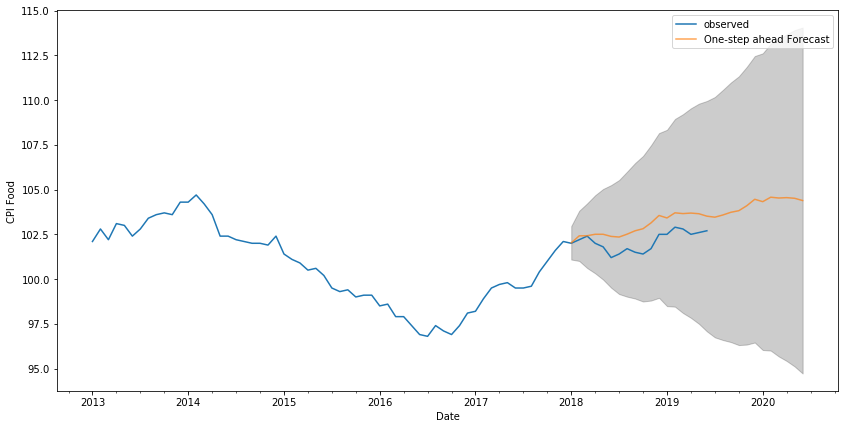

In [279]:
# we visualise forecasts from the model for the next 12 months
pred = results.get_prediction(start=pd.to_datetime('01-01-2018'), end = pd.to_datetime('06-2020'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts['2013-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CPI Food')
plt.legend()
plt.show()

In [75]:
# We take a look at the %Mean Absolute Error generated by this model 
# to see if our SARIMA model meets the requirement of our brief.
pred = results.get_prediction(start=pd.to_datetime('01-01-2018'), end = pd.to_datetime('06-2020'), dynamic=False)
y_pred = pred.predicted_mean
np.mean(np.abs(y_pred - test)/np.abs(test))*100

0.8252859988528594

The average %Mean Absolute Error is 0.82% and is larger than the threshold we set out in the brief (0.50%) for our error tolerance.

## 6. Evaluation and Conclusion

**[Conclusions to data questions]** <br>
We conclude that univariate models are inadequate to predict future CPI levels within 0.50% error and is not accurate enough for business application. The %MAE of our most optimal model SARIMA(1,1,1)(1,0,1)12 which yielded the smallest AIC from our gridsearch had a %MAE of 0.83%. 


**[Avenues for further study and limitations of the model]** <br>
Being a univariate model, the model relies on past values of itself and effects of historical disturbances and can only model how an exogenous shock propagates through the system. The model is unable to predict turning points in underlying stochastic trend. To improve predictability, more advanced modelling technique can include: introducing exogenous regressors and multivariate models e.g. Vector Auto Regressive models.